- [1] 모듈 로딩 <hr>

In [94]:
### ===> Module Import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [95]:
### ===> 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.0  Device: cpu


- [2] 데이터 준비 <hr>

In [96]:
### ===>  데이터 추출 관련 변수
BATCH_SIZE = 32
EPOCHS = 10

In [97]:
### ===> CIFAR10 데이터 다운로드 (Train set, Test set 분리하기)
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [98]:
### ===>  데이터 확인하기 (1)
# 32, 3, 32, 32 => 배치사이즈, 채널, 높이, 너비 
# 32 => 배치사이즈의 32개 이미지에 대한 라벨 
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


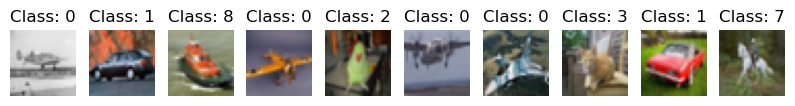

In [99]:
### ===>  데이터 확인하기 (2) 
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

- [3] 모델 설계 <hr>

In [100]:
# X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor 32, 3, 32, 32 
# => 배치사이즈, 채널, 높이, 너비 

# y_train: torch.Size([32]) type: torch.LongTensor 
# 32 => 배치사이즈의 32개 이미지에 대한 라벨 

### ===>  Convolutional Neural Network (CNN) 모델 설계하기
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # in rgb, 커널은 8개 준비고했고 사이즈는 3*3짜리얌
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1) # 커널이 8개면 결과도 8개 
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        # 풀링을 줘서 줄임
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64) # 16장 
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10) # 마지막 출력은 라벨의 개수인 10개 
        
    def forward(self, x):
        x = self.conv1(x) #
        x = F.relu(x) 
        x = self.pool(x) # 반으로 줄어
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16) # 1024
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

- [4] 학습 준비 <hr>

In [101]:
### ===> Optimizer, Objective Function 설정
model = CNN().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [102]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/CIFAR_10
    Split: Train
    StandardTransform
Transform: ToTensor()

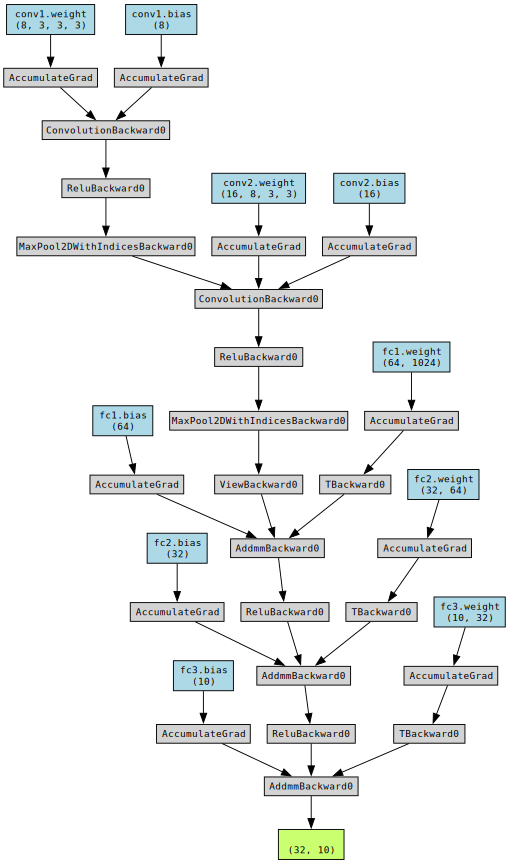

In [103]:
from torchviz import make_dot

make_dot(model(X_train),params=dict(model.named_parameters()))

In [104]:
### ===> CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}")

In [105]:
### ===> 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

- [5] 학습진행 <hr>

In [106]:
### ===> CNN 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인
for epoch in range(1, EPOCHS + 1):
    
    train(epoch, model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

Train Epoch: 1 [0]	Train Loss: 2.289786
Train Epoch: 1 [200]	Train Loss: 1.952814
Train Epoch: 1 [400]	Train Loss: 1.979422
Train Epoch: 1 [600]	Train Loss: 1.616982
Train Epoch: 1 [800]	Train Loss: 1.580937
Train Epoch: 1 [1000]	Train Loss: 1.569299
Train Epoch: 1 [1200]	Train Loss: 1.720408
Train Epoch: 1 [1400]	Train Loss: 1.497766

[EPOCH: 1], 	Test Loss: 0.0469, 	Test Accuracy: 44.69 % 

Train Epoch: 2 [0]	Train Loss: 1.636360
Train Epoch: 2 [200]	Train Loss: 1.502967
Train Epoch: 2 [400]	Train Loss: 1.800873
Train Epoch: 2 [600]	Train Loss: 1.239702
Train Epoch: 2 [800]	Train Loss: 1.287044
Train Epoch: 2 [1000]	Train Loss: 1.508467
Train Epoch: 2 [1200]	Train Loss: 1.366319
Train Epoch: 2 [1400]	Train Loss: 1.396730

[EPOCH: 2], 	Test Loss: 0.0417, 	Test Accuracy: 51.41 % 

Train Epoch: 3 [0]	Train Loss: 1.611027
Train Epoch: 3 [200]	Train Loss: 1.461724
Train Epoch: 3 [400]	Train Loss: 1.285340
Train Epoch: 3 [600]	Train Loss: 1.443564
Train Epoch: 3 [800]	Train Loss: 1.275908


In [107]:
a = np.arange(4).reshape(2,2)
a

array([[0, 1],
       [2, 3]])

In [108]:
b = np.arange(10, 14).reshape(2,2)
b

array([[10, 11],
       [12, 13]])

In [109]:
np.vstack((a,b)), np.concatenate((a, b), axis=0), np.vstack((a,b)).shape

(array([[ 0,  1],
        [ 2,  3],
        [10, 11],
        [12, 13]]),
 array([[ 0,  1],
        [ 2,  3],
        [10, 11],
        [12, 13]]),
 (4, 2))

In [110]:
np.hstack((a, b)), np.concatenate((a, b), axis=1), np.hstack((a, b)).shape

(array([[ 0,  1, 10, 11],
        [ 2,  3, 12, 13]]),
 array([[ 0,  1, 10, 11],
        [ 2,  3, 12, 13]]),
 (2, 4))

In [111]:
a = np.arange(12).reshape(4, 3)
b = np.arange(10, 130, 10).reshape(4, 3)
a, b

(array([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]]),
 array([[ 10,  20,  30],
        [ 40,  50,  60],
        [ 70,  80,  90],
        [100, 110, 120]]))

In [112]:
np.stack((a,b)), np.stack((a,b)).shape

(array([[[  0,   1,   2],
         [  3,   4,   5],
         [  6,   7,   8],
         [  9,  10,  11]],
 
        [[ 10,  20,  30],
         [ 40,  50,  60],
         [ 70,  80,  90],
         [100, 110, 120]]]),
 (2, 4, 3))

장? 수가 0번 -> 2
row가 1번 -> 4
col이 2번 -> 3

In [113]:
c = np.stack((a,b), axis=1)
c, c.shape

(array([[[  0,   1,   2],
         [ 10,  20,  30]],
 
        [[  3,   4,   5],
         [ 40,  50,  60]],
 
        [[  6,   7,   8],
         [ 70,  80,  90]],
 
        [[  9,  10,  11],
         [100, 110, 120]]]),
 (4, 2, 3))

 ---

In [114]:
a = np.arange(12)
print(a)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [115]:
print(f"a => {a}")
print(np.hsplit(a, 3))

a => [ 0  1  2  3  4  5  6  7  8  9 10 11]
[array([0, 1, 2, 3]), array([4, 5, 6, 7]), array([ 8,  9, 10, 11])]


In [116]:
print(f"a => {a}")
print(np.split(a, [3, 6]))

a => [ 0  1  2  3  4  5  6  7  8  9 10 11]
[array([0, 1, 2]), array([3, 4, 5]), array([ 6,  7,  8,  9, 10, 11])]


In [117]:
b = np.arange(12).reshape(3, 4)
b

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [118]:
coords = np.where(b>6)
coords, coords[0].shape

((array([1, 2, 2, 2, 2], dtype=int64), array([3, 0, 1, 2, 3], dtype=int64)),
 (5,))

In [119]:
# (5,)

In [120]:
np.stack((coords[0], coords[1]), 0)

array([[1, 2, 2, 2, 2],
       [3, 0, 1, 2, 3]], dtype=int64)

In [121]:
tt = np.array([[True, True],[False, True],[True, True]])
tt, tt.shape

(array([[ True,  True],
        [False,  True],
        [ True,  True]]),
 (3, 2))

In [122]:
c[2, 1, 2] = 0

In [90]:
c, c.shape

(array([[[  0,   1,   2],
         [ 10,  20,  30]],
 
        [[  3,   4,   5],
         [ 40,  50,  60]],
 
        [[  6,   7,   8],
         [ 70,  80,   0]],
 
        [[  9,  10,  11],
         [100, 110, 120]]]),
 (4, 2, 3))

In [91]:
np.all(c, 0)

array([[False,  True,  True],
       [ True,  True, False]])

In [92]:
np.all(c, 1)

array([[False,  True,  True],
       [ True,  True,  True],
       [ True,  True, False],
       [ True,  True,  True]])

In [93]:
np.all(c, 2)

array([[False,  True],
       [ True,  True],
       [ True, False],
       [ True,  True]])